In [3]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import xgboost as xgb

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit

sb.set()

# Exploratory Data Analysis
Some prior knowledge about Singapore's Rainfall Pattern before we analyse our dataset:

Singapore rainfall distribution contains as annual trend, with high amount of rain around the period of Nov to Jan and May to Jul, due to the prevailing Northeast (NE) and Southwest (SW) Monsoon respectively.

![Singapore's Monsoon Pattern](data/Monsoon.jpg)

Let's pull our cleaned dataset from earlier for the analysis.

In [4]:
rainData = pd.read_csv('data/rainData.csv')
rainData['Date'] = pd.to_datetime(rainData['Date'], infer_datetime_format=True)
rainData = rainData.set_index('Date')
rainData = rainData.sort_index()
rainData.drop(columns={'Year','Month','Day'}).tail()

,Daily Rainfall Total (mm),Mean Temperature (°C),Mean Humidity (%)
Date,,,
2023-03-27,19.4,26.0,90.7
2023-03-28,0.0,28.8,80.6
2023-03-29,0.0,28.8,79.7
2023-03-30,9.2,28.4,80.3
2023-03-31,0.0,28.7,80.1


In [5]:
rainData.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3652 entries, 2013-04-01 to 2023-03-31
Data columns (total 6 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Year                       3652 non-null   int64  
 1   Month                      3652 non-null   int64  
 2   Day                        3652 non-null   int64  
 3   Daily Rainfall Total (mm)  3652 non-null   float64
 4   Mean Temperature (°C)      3652 non-null   float64
 5   Mean Humidity (%)          3652 non-null   float64
dtypes: float64(3), int64(3)
memory usage: 199.7 KB


We see the Daily Rainfall Total (mm), Mean Temperature (°C), and Mean Humidity (%) are numerical variables. As we're analysing weather data, it is more useful to consider Year, Month and Day as Categorical (Date) Variables even though they are numerical. This allows us to group the data by month or years to look for seasonal patterns in rainfall.

Next, let's identify any outliers that may affect our machine learning later.

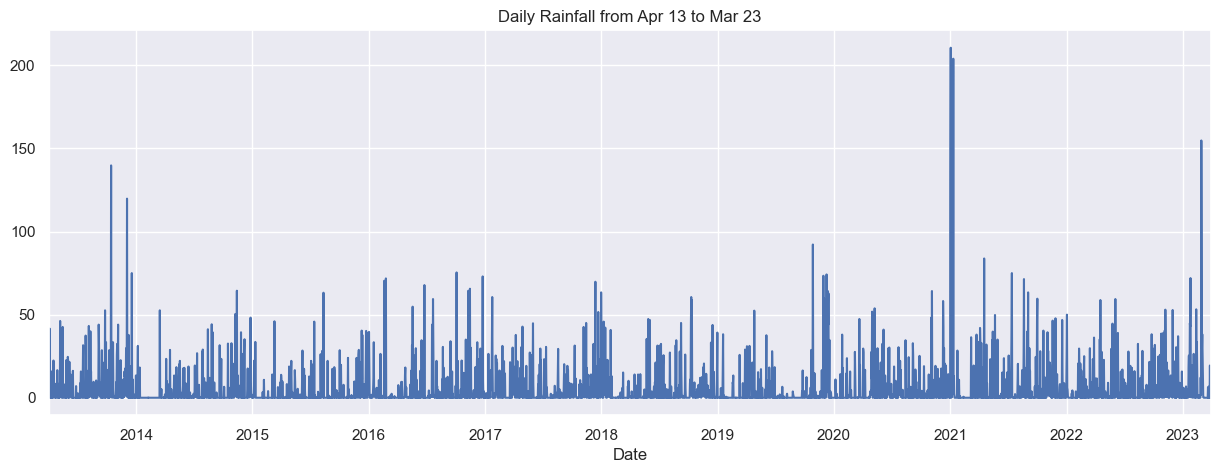

Dataset Until:


Timestamp('2023-03-31 00:00:00')

In [6]:
# Full Dataset
f, axes = plt.subplots(figsize=(15, 5))
rainData.plot(ax=axes, y='Daily Rainfall Total (mm)', title='Daily Rainfall from Apr 13 to Mar 23', legend=False)
plt.show()

print("Dataset Until:")
rainData.index.max()

Notice that there are periods in 2013, 2021 and 2023 where the rainfall is excpetionally high compared to the rest of our dataset. We consider period where daily rainfall is > 100mm as outliers and remove them from our dataset.

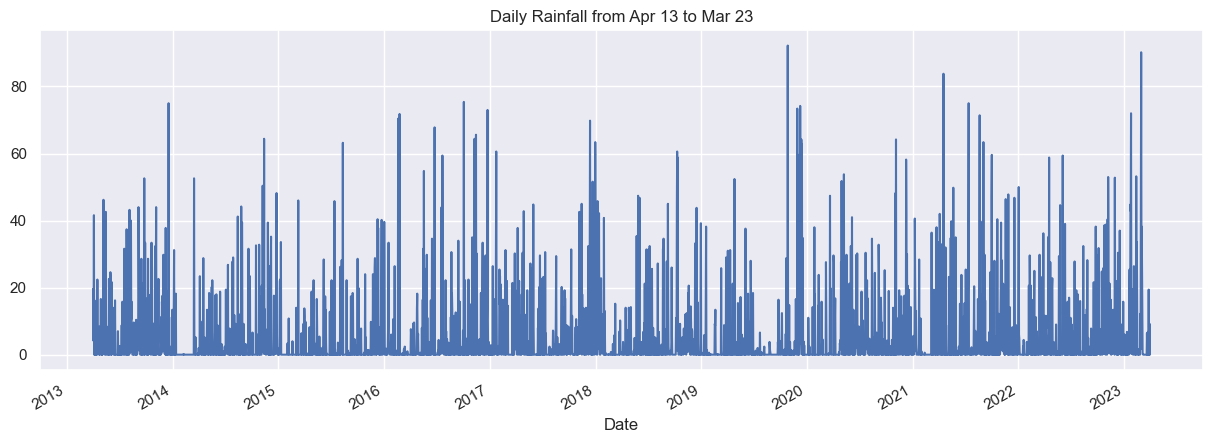

In [7]:
# Remove Outlier
rainData = rainData[rainData['Daily Rainfall Total (mm)'] <= 100]

f, axes = plt.subplots(figsize=(15, 5))
rainData.plot(ax=axes, y='Daily Rainfall Total (mm)', title='Daily Rainfall from Apr 13 to Mar 23', legend=False)
plt.show()

We want to see the average seasonal trend of the daily recorded rainfall amount throughout each year, in order to know what to expect for our machine learning.

Notice that the time series graph looks noisy due to rainfall fluctuations between different days. Since there's no "trend" when comparing daily observations only, we'll do a moving average of the recorded rainfall in a monthly window to smooth out the noise, so that we are better able to see the trend.

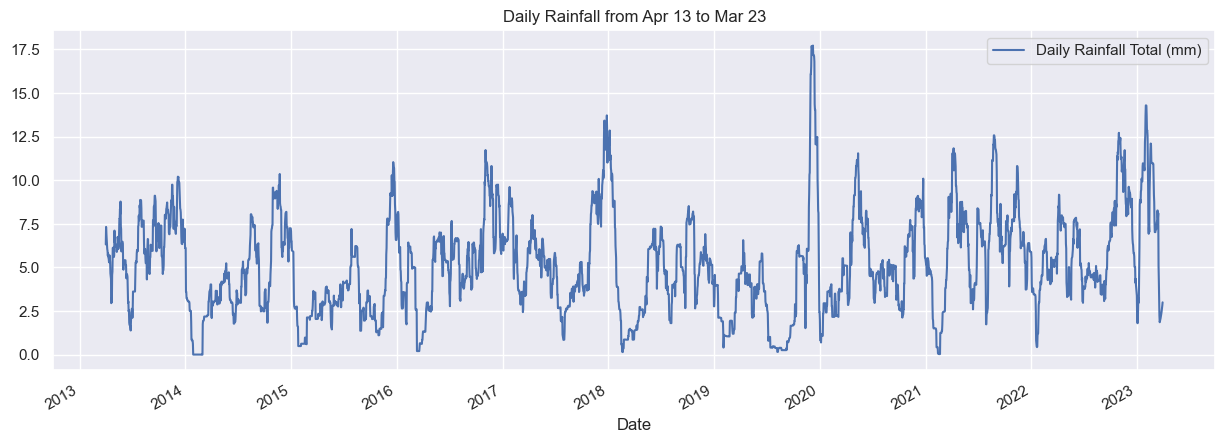

In [8]:
#Moving Average of rainfall across each month
mov_avg = rainData.rolling(window=30, center=True, min_periods=15).mean()

f, axes = plt.subplots(figsize=(15, 5))
mov_avg.plot(ax=axes, y='Daily Rainfall Total (mm)', title='Daily Rainfall from Apr 13 to Mar 23')
plt.show()

Now we begin to see a pattern of daily rainfall across every year. However it's hard to analyse the seasonal trend when the data from different years are clustered together. Let's analyse from a boxplot the average daily rainfall across different months of each year instead.

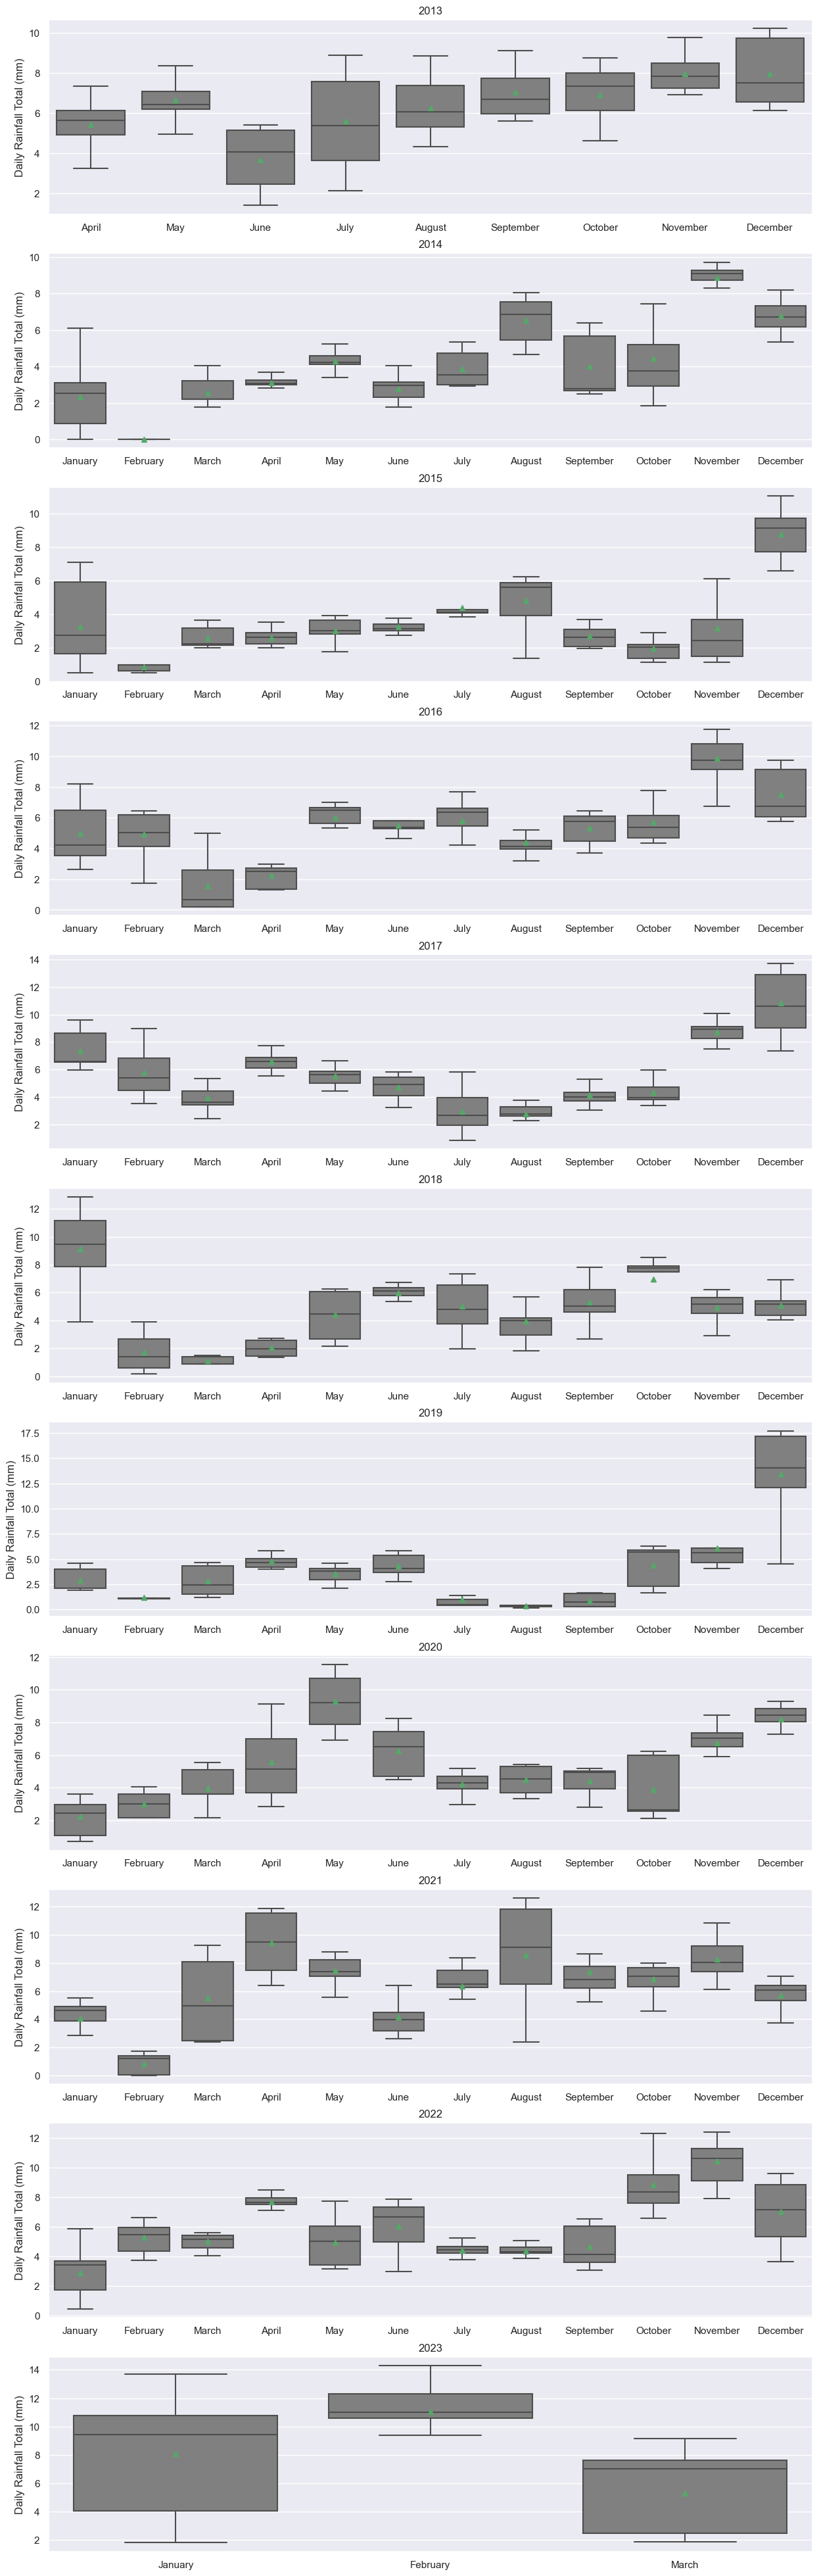

In [84]:
f, axes = plt.subplots(11, 1, figsize=(15, 50))
count = 0;

for x in mov_avg.index.year.unique():
    df = mov_avg[mov_avg.index.year == x]
    sb.boxplot(ax=axes[count], data=df, x=df.index.month_name(), 
          y='Daily Rainfall Total (mm)', showmeans=True, showfliers = False, color='grey', labels=None).set_title(x)
    axes[count].set(xlabel=None)
    
    count += 1
    
plt.show()

Notice as the rainfall distribution of every year behaves slightly differently, it is hard to derive general the annual trend by looking at data from different years. 

Let's average the records of each month from different years for a clearer view of the annual trend of rainfall distribution. By calculating the monthly averages over a number of years, we smooth variations from different years and focus on the longer-term patterns.

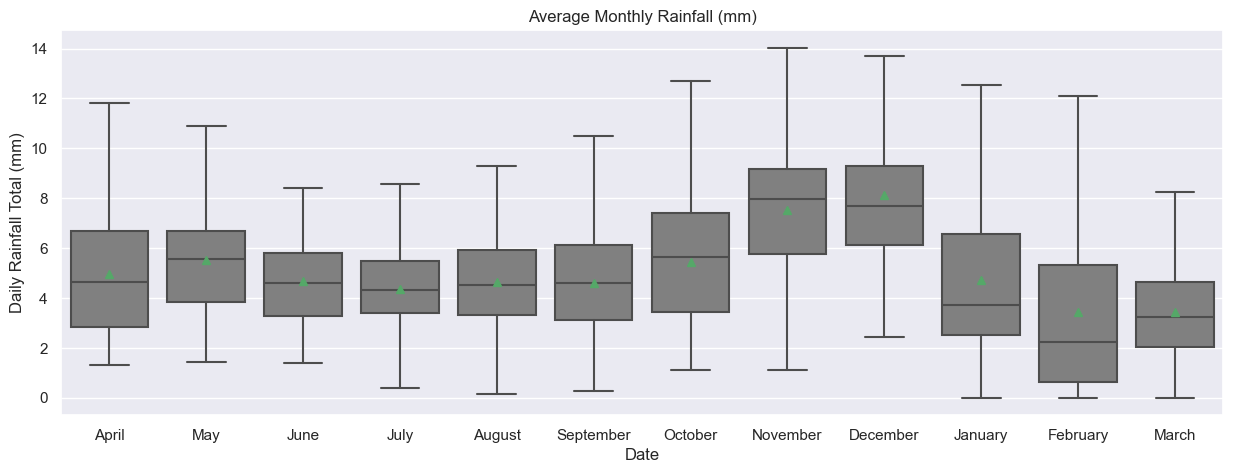

In [85]:
f = plt.figure(figsize=(15, 5))
sb.boxplot(data=mov_avg, x=mov_avg['Month'].index.month_name(), 
           y='Daily Rainfall Total (mm)', showmeans=True, showfliers = False, color='grey').set_title('Average Monthly Rainfall (mm)')

plt.show()

We can see from our dataset that the daily recorded rainfall are slightly high between April → June and notably high between November → December. This resembles closely to the annual trend we saw from the image earlier. The trend can be seen clearer from the mean daily rainfall of eaech month, as indicated by the green triangle in each boxplots. Note that we've removed outliers from the boxplots as they do not add any value to our analysis.

Even though the monsoon periods seem to happen slightly earlier in our dataset, the rainfall pattern still observes the general behaviour of the theoretical explanation, where inter-monsoon periods experiences lower rainfall compared to those of the NE and SW monsoon.

Let's also see what are variables in our dataset affect the daily rainfall recorded.

<AxesSubplot:>

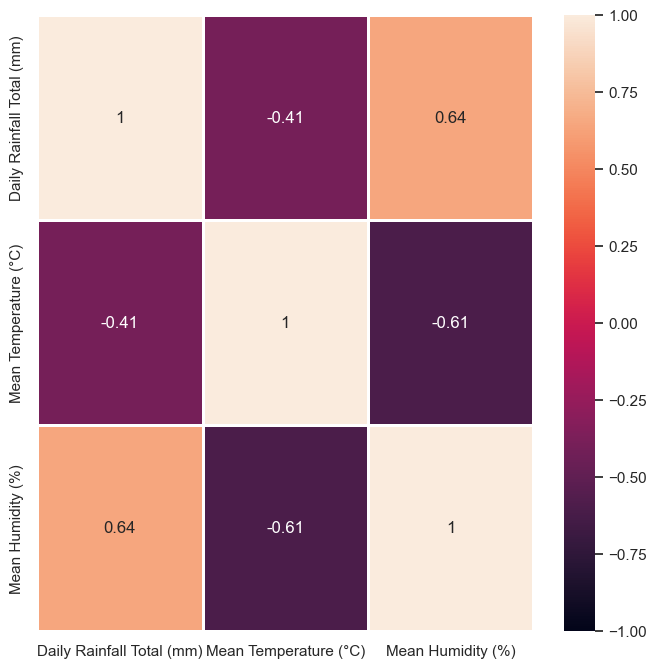

In [25]:
f = plt.figure(figsize=(8, 8))
sb.heatmap(mov_avg.drop(columns={'Year', 'Month', 'Day'}).corr(), vmin=-1, vmax=1, linewidth=1, annot=True)

We can see from the correlation matrix that as generally as 
- Mean Temperature (°C) decreases, Total Rainfall increases.
- Mean Humidity (%) increases, Total Rainfall increases.

This, however, may not happen all the time, as their correlation coefficient is not 1/-1. Let's look a graphical representation of their correlation to confirm this theory.

<Figure size 1500x500 with 0 Axes>

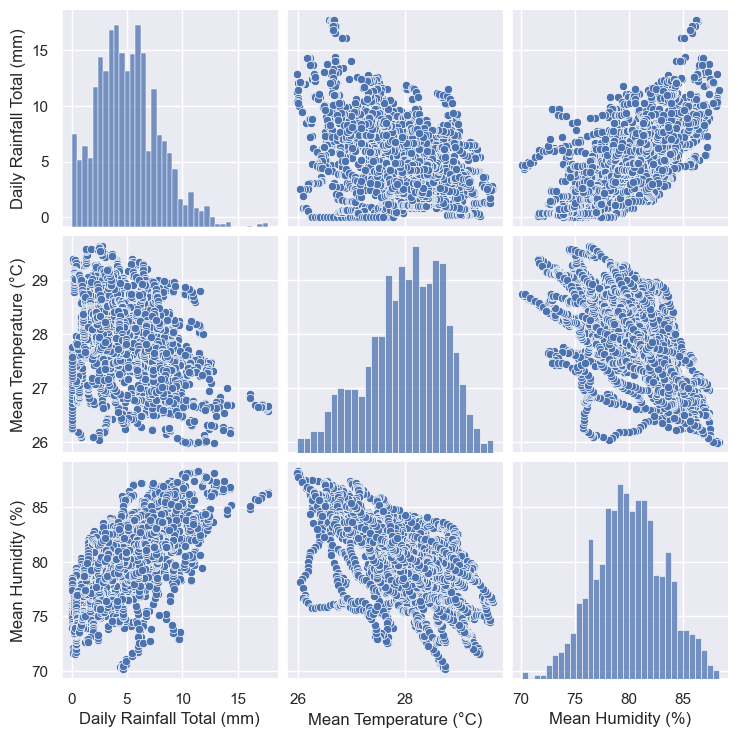

In [26]:
f = plt.figure(figsize=(15, 5))
sb.pairplot(data=mov_avg.drop(columns={'Year', 'Month', 'Day'}))

plt.show()

We can see from the graph that indicates Mean Temperature against Daily Rainfall Total, there are times where Mean Temperature is higher, but Daily Rainfall Total is also high. The same can be said for Mean Humidity.

Let's export the dataset with outliers removed for our Machine Learning.

In [12]:
rainData.to_csv('data/rainData_noOutliers.csv')

# References

Meterological Service Singapore. Climate of Singapore
www.weather.gov.sg/climate-climate-of-singapore/

Ryan H.(Year Unknown) Trend
https://www.kaggle.com/code/ryanholbrook/trend